# **Генерация маски дефектов**

In [1]:
!pip install torchmetrics -q
!pip install segmentation_models_pytorch -q

In [6]:
import os
import random
import requests
import numpy as np
from io import BytesIO
from typing import Any, Callable, Optional, Union
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, Subset, DataLoader
from torch import Tensor

from torchmetrics.metric import Metric
import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Размер изображений
size = 256

# Путь к папке с изображениями
imgs_path = '/kaggle/input/coco-2017-dataset/coco2017/test2017/'

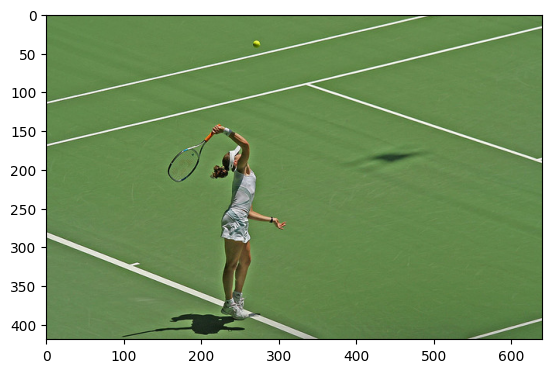

In [3]:
# Получение списка файлов в папке
coco_imgs_names = os.listdir(imgs_path)

# Выбор случайного имени изображения
random_image_name = random.choice(coco_imgs_names)

# Составление полного пути к изображению
image_path = os.path.join(imgs_path, random_image_name)

# Чтение изображения с использованием OpenCV
image = cv2.imread(image_path)

# Преобразование изображения из формата BGR в RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Отображение изображения
plt.imshow(image);

In [4]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(
            mask == 1,
            image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
            image[:, :, c]
        )
    return image

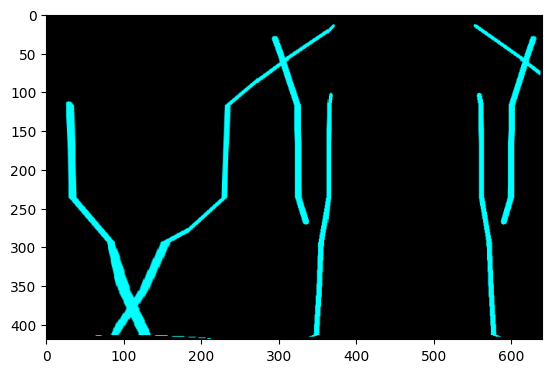

In [5]:
mask = np.zeros(image.shape, np.uint8)
for i in range(random.randint(1, 16)):
    mask = cv2.line(
        mask,
        (random.randint(0, image.shape[1]), random.randint(0, image.shape[0])), 
        (random.randint(0, image.shape[1]), random.randint(0, image.shape[0])), 
        (1, 255, 255),
        random.randint(3, 15)
    )

mask = A.GridDistortion(
    num_steps=7, distort_limit=(-1, 1), p=1
)(image=mask)['image']

plt.imshow(mask.astype(np.uint8))
plt.show()

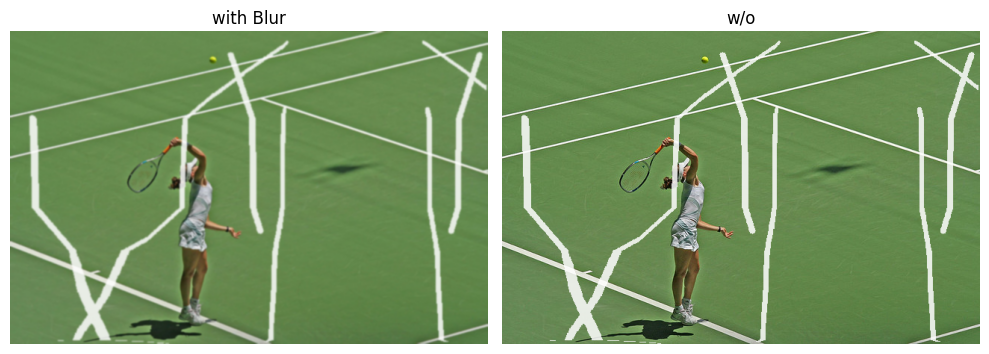

In [6]:
bad_image = apply_mask(
    image.copy(),
    np.squeeze(mask[:,:,:1], 2),
    (1, 1, 1), alpha=0.85
)

bad_image_blured = cv2.GaussianBlur(bad_image, (5, 5), 1)

# Создание фигуры и подграфиков
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# Отображение чистого изображения
ax[0].imshow(bad_image_blured)
ax[0].set_title('with Blur')
ax[0].axis('off')  # Отключение осей

# Отображение зашумленного изображения
ax[1].imshow(bad_image)
ax[1].set_title('w/o')
ax[1].axis('off')  # Отключение осей

# Отображение графиков
plt.tight_layout()
plt.show()

In [3]:
class DefectDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_folder, image_file)
        # Загрузка изображения
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)
        
        # Генерация маски дефектов
        mask = np.zeros(image.shape[:2], np.uint8)
        for i in range(np.random.randint(1, 16)):
            mask = cv2.line(
                mask,
                (np.random.randint(0, image.shape[1]), np.random.randint(0, image.shape[0])), 
                (np.random.randint(0, image.shape[1]), np.random.randint(0, image.shape[0])), 
                (1),
                np.random.randint(3, 15)
            )
        
        # Искажение маски
        mask = A.GridDistortion(
            num_steps=7, distort_limit=(-1, 1), p=1
        )(image=mask)['image']

        # Объединение маски и изображения
        bad_image = self.apply_mask(image.copy(), mask, (1, 1, 1), alpha=0.85)
        
        # Добавим лёгкое размытие
        bad_image = cv2.GaussianBlur(bad_image, (5, 5), 0)

        if self.transform:
            augmented = self.transform(image=bad_image, mask=mask)
            bad_image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)

        return bad_image, mask

    def apply_mask(self, image, mask, color, alpha=0.5):
        for c in range(3):
            image[:, :, c] = np.where(
                mask == 1,
                image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                image[:, :, c]
            )
        return image

In [4]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


transform = A.Compose([
    A.Resize(height=size, width=size, p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

In [7]:
dataset = DefectDataset(imgs_path, transform=transform)

datasets = train_val_dataset(dataset)
train_dataset = datasets['train']
val_dataset = datasets['val']

batch_size = 16

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=False,
    pin_memory=True
)

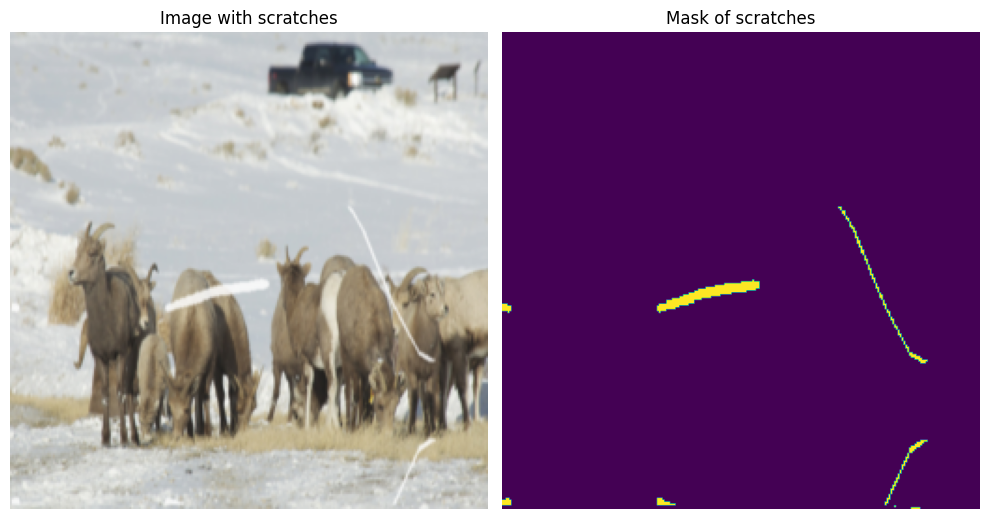

In [90]:
# Пример получения изображений из вашего набора данных
bad_image, mask = train_dataset[1000]

# Преобразование тензоров в массивы NumPy и приведение значений к диапазону [0, 255]
bad_image = bad_image.permute(1, 2, 0).numpy()
mask = mask.permute(1, 2, 0).numpy()

# Создание фигуры и подграфиков
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# Отображение чистого изображения
ax[0].imshow(bad_image)
ax[0].set_title('Image with scratches')
ax[0].axis('off')  # Отключение осей

# Отображение зашумленного изображения
ax[1].imshow(mask)
ax[1].set_title('Mask of scratches')
ax[1].axis('off')  # Отключение осей

# Отображение графиков
plt.tight_layout()
plt.show()

In [52]:
__all__ = ["SoftBCEWithLogitsLoss"]


class SoftBCEWithLogitsLoss(nn.Module):
    __constants__ = ["weight", "pos_weight", "reduction", "ignore_index", "smooth_factor"]

    def __init__(
            self,
            weight: Optional[torch.Tensor] = None,
            ignore_index: Optional[int] = -100,
            reduction: str = "mean",
            smooth_factor: Optional[float] = None,
            pos_weight: Optional[torch.Tensor] = None,
    ):
        """Drop-in replacement for torch.nn.BCEWithLogitsLoss with few additions: ignore_index and label_smoothing

        Args:
            ignore_index: Specifies a target value that is ignored and does not contribute to the input gradient.
            smooth_factor: Factor to smooth target (e.g. if smooth_factor=0.1 then [1, 0, 1] -> [0.9, 0.1, 0.9])

        Shape
             - **y_pred** - torch.Tensor of shape NxCxHxW
             - **y_true** - torch.Tensor of shape NxHxW or Nx1xHxW

        Reference
            https://github.com/BloodAxe/pytorch-toolbelt

        """
        super().__init__()
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.smooth_factor = smooth_factor
        self.register_buffer("weight", weight)
        self.register_buffer("pos_weight", pos_weight)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Args:
            y_pred: torch.Tensor of shape (N, C, H, W)
            y_true: torch.Tensor of shape (N, H, W)  or (N, 1, H, W)

        Returns:
            loss: torch.Tensor
        """

        if self.smooth_factor is not None:
            soft_targets = (1 - y_true) * self.smooth_factor + y_true * (1 - self.smooth_factor)
        else:
            soft_targets = y_true

        loss = F.binary_cross_entropy_with_logits(
            y_pred, soft_targets, self.weight, pos_weight=self.pos_weight, reduction="none"
        )

        if self.ignore_index is not None:
            not_ignored_mask = y_true != self.ignore_index
            loss *= not_ignored_mask.type_as(loss)

        if self.reduction == "mean":
            loss = loss.mean()

        if self.reduction == "sum":
            loss = loss.sum()

        return loss

    
class AverageMeter(Metric):
    """Computes the average of a stream of values.

    Forward accepts
        - ``value`` (float tensor): ``(...)``
        - ``weight`` (float tensor): ``(...)``

    Args:
        compute_on_step:
            Forward only calls ``update()`` and returns None if this is
            set to False. default: True
        dist_sync_on_step:
            Synchronize metric state across processes at each ``forward()``
            before returning the value at the step.
        process_group:
            Specify the process group on which synchronization is called.
            default: None (which selects the entire world)
        dist_sync_fn:
            Callback that performs the allgather operation on the metric state.
            When `None`, DDP will be used to perform the allgather.

    Example::
        >>> from torchmetrics import AverageMeter
        >>> avg = AverageMeter()
        >>> avg.update(3)
        >>> avg.update(1)
        >>> avg.compute()
        tensor(2.)

        >>> avg = AverageMeter()
        >>> values = torch.tensor([1., 2., 3.])
        >>> avg(values)
        tensor(2.)

        >>> avg = AverageMeter()
        >>> values = torch.tensor([1., 2.])
        >>> weights = torch.tensor([3., 1.])
        >>> avg(values, weights)
        tensor(1.2500)
    """
    value: Tensor
    weight: Tensor

    def __init__(
        self,
        compute_on_cpu: bool = True,
        dist_sync_on_step: bool = False,
        process_group: Optional[Any] = None,
        dist_sync_fn: Callable = None,
    ) -> None:
        super().__init__(
            compute_on_cpu=compute_on_cpu,
            dist_sync_on_step=dist_sync_on_step,
            process_group=process_group,
            dist_sync_fn=dist_sync_fn,
        )
        self.add_state("value", torch.zeros(()), dist_reduce_fx="sum")
        self.add_state("weight", torch.zeros(()), dist_reduce_fx="sum")

    def update(  # type: ignore
        self, value: "Union[Tensor, float]", weight: "Union[Tensor, float]" = 1.0
    ) -> None:
        """Updates the average with.

        Args:
            value: A tensor of observations (can also be a scalar value)
            weight: The weight of each observation (automatically broadcasted
                to fit ``value``)
        """
        if not isinstance(value, Tensor):
            value = torch.as_tensor(value, dtype=torch.float32, device=self.value.device)
        if not isinstance(weight, Tensor):
            weight = torch.as_tensor(weight, dtype=torch.float32, device=self.weight.device)

        # braodcast_to only supported on PyTorch 1.8+
        if not hasattr(torch, "broadcast_to"):
            if weight.shape == ():
                weight = torch.ones_like(value) * weight
            if weight.shape != value.shape:
                raise ValueError("Broadcasting not supported on PyTorch <1.8")
        else:
            weight = torch.broadcast_to(weight, value.shape)

        self.value += (value * weight).sum()
        self.weight += weight.sum()

    def compute(self) -> Tensor:
        return self.value / self.weight

    
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [105]:
model = smp.UnetPlusPlus(encoder_name='timm-regnetx_002').cuda()
    
criterion = SoftBCEWithLogitsLoss()
learning_rate = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-5, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
scaler = torch.amp.GradScaler('cuda')

train_losses = AverageMeter().cuda()
val_losses = AverageMeter().cuda()
train_iou = AverageMeter().cuda()
val_iou = AverageMeter().cuda()
best_metric = torch.tensor(-9999)
best_loss = 99999999
n_rounds = 4
k = 0
iters = len(train_dataloader)

In [1]:
epoch_train_losses = []
epoch_val_losses = []
epoch_train_iou = []
epoch_val_iou = []

for epoch in range(300):
    # Reset loss and IoU metrics
    train_losses.reset()
    val_losses.reset()
    train_iou.reset()
    val_iou.reset()

    print('Training...')
    print(('\n' + '%10s' * 5) % ('Epoch', 'gpu_mem', 'cls', 'labels', 'img_size'))
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar

    is_early_stopping = False
    model.train()
    for idx, batch in pbar:
        x, y = batch
        x, y = x.float().cuda() / 255, y.float().cuda()
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            output = model(x)
        loss = criterion(output, y)
        train_losses.update(loss)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step(epoch + idx / iters)

        iou = calc_iou(output.detach().cpu().numpy(), y.detach().cpu().numpy())
        train_iou.update(iou)

        mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'  # (GB)
        pbar.set_description(
            ('%10s' * 2 + '%10.4g' * 3) % (f'{epoch}', mem, train_losses.compute().cpu().item(),
                                            y.shape[0], img_size[-1]))

    # Save training loss and IoU
    epoch_train_losses.append(train_losses.compute().cpu().item())
    epoch_train_iou.append(train_iou.compute().cpu().item())

    if best_loss > round(train_losses.compute().cpu().item(), 6):
        best_loss = round(train_losses.compute().cpu().item(), 6)
        k = 0
    elif k == n_rounds:
        is_early_stopping = True
    else:
        k += 1

    print("Training results: \n"
          f"Mean Loss: {epoch_train_losses[-1]}, Mean IoU: {epoch_train_iou[-1]}")

    if is_early_stopping:
        print(f"Early stopping at epoch {epoch}")
        break

    # Validation
    model.eval()
    print(f'\nValidating...')
    print(('\n' + '%10s' * 6) % ('Epoch', 'gpu_mem', 'cls', 'labels', 'img_size', 'metric'))
    pbar = tqdm(val_dataloader, total=len(val_dataloader),
                bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar

    for batch in pbar:
        x, y = batch
        x, y = x.float().cuda()/255, y.float().cuda()

        with torch.no_grad():
            output = model(x)
        loss = criterion(output, y)
        val_losses.update(loss)

        iou = calc_iou(output.detach().cpu().numpy(), y.detach().cpu().numpy())
        val_iou.update(iou)

        mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'  # (GB)
        pbar.set_description(('%10s' * 2 + '%10.4g' * 4) % (
            f'{epoch}', mem, val_losses.compute().cpu().item(), y.shape[0], img_size[-1],
            val_iou.compute().cpu().item()))

    current_val_iou = val_iou.compute().cpu().item()
    epoch_val_losses.append(val_losses.compute().cpu().item())
    epoch_val_iou.append(current_val_iou)

    if current_val_iou > best_metric:
        torch.save(model.state_dict(), "best.pt")
        best_metric = current_val_iou

    print("Validation results: \n"
          f"Mean Loss: {epoch_val_losses[-1]}, Mean IoU: {epoch_val_iou[-1]}")

    torch.save(model.state_dict(), "last.pt")

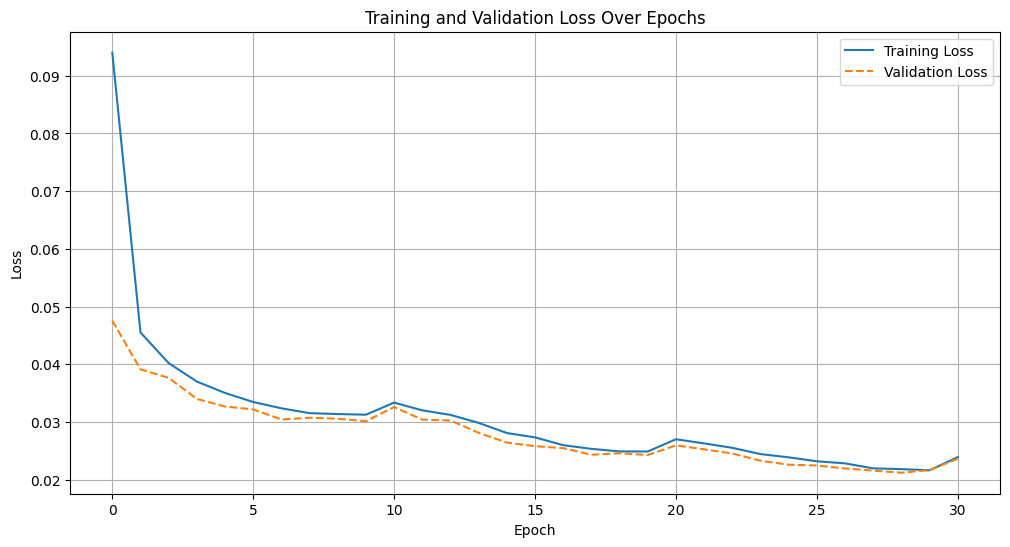

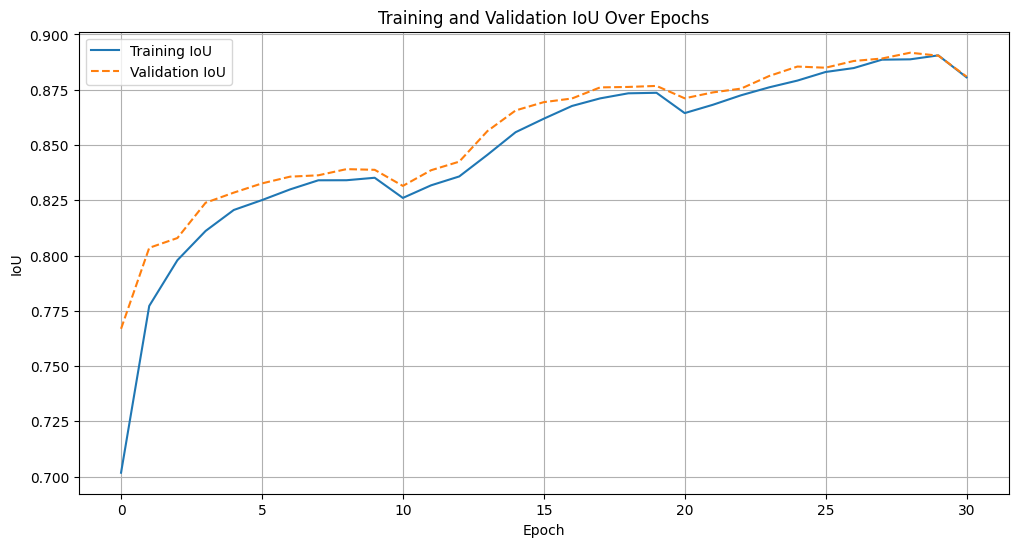

In [108]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

# Plot training and validation IoU
plt.figure(figsize=(12, 6))
plt.plot(epoch_train_iou, label='Training IoU')
plt.plot(epoch_val_iou, label='Validation IoU', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('iou_plot.png')
plt.show()

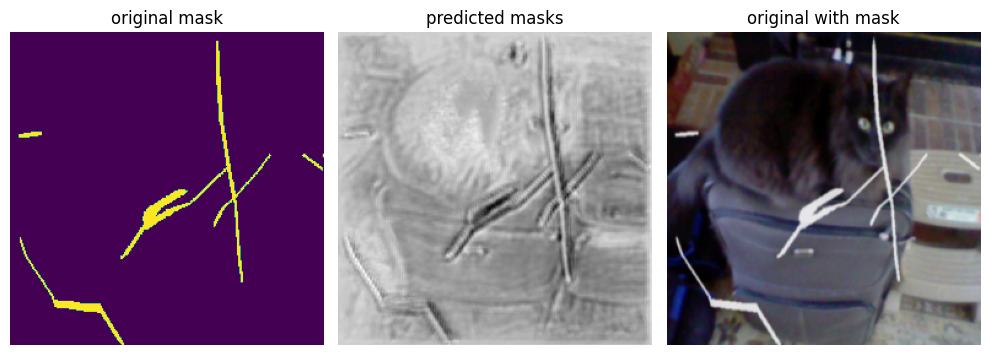

In [30]:
# Параметры модели
# model_path = '/kaggle/working/best.pt'
model_path = '/kaggle/input/best_unetplusplus/pytorch/default/1/best.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Инициализация модели
model = smp.UnetPlusPlus(encoder_name='timm-regnetx_002').cuda()
# Загрузка state_dict
model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)
model.eval()

# Загрузка изображения
def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return np.array(image)


# Преобразование изображеня
def preprocess_image(image):
    transform = A.Compose([
        A.Resize(height=size, width=size, p=1),
        ToTensorV2()
    ])
    image = transform(image=image)['image']
    image = image.unsqueeze(0)
    return image

# Основная функция
def predict(image_url):
    image = load_image_from_url(image_url)
    input_image = preprocess_image(image).to(device)

    with torch.no_grad():
        output = model(input_image.float())

    return output

# URL изображения для тестирования
image_url = 'https://club.dns-shop.ru/api/v1/image/getOriginal/q93_bd7d28ece7d017b7603d6d54f4a0afc42394c8c8fd66929dc895b18e18040aef.jpg'
# Предсказание маски для стокового изображения
# predicted_mask = predict(image_url).cpu()[0].numpy().squeeze()
# Предсказание маски для изображения из валидационной выборки
# Генерируем случайный индекс
random_index = random.randint(0, len(val_dataset) - 1)
bad_image, mask = val_dataset[random_index]
predicted_mask = model(
    bad_image.float().unsqueeze(0).to(device)
).cpu()[0].detach().numpy().squeeze()
# height, width, _ = load_image_from_url(image_url).shape
# predicted_mask_resized = A.Resize(
#     height=height, width=width
# )(image=predicted_mask)['image']

# Создание фигуры и подграфиков
fig, ax = plt.subplots(1, 3, figsize=(10, 8))

# Отображение маски изображения
# ax[0].imshow(load_image_from_url(image_url))
ax[0].imshow(mask.permute(1, 2, 0))
ax[0].set_title('original mask')
ax[0].axis('off')  # Отключение осей

# Отображение предсказания маски
# ax[1].imshow(predicted_mask_resized, cmap='gray')
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].set_title('predicted masks')
ax[1].axis('off')  # Отключение осей

# Отображение исходного изображения
ax[2].imshow(bad_image.permute(1, 2, 0))
ax[2].set_title('original with mask')
ax[2].axis('off')  # Отключение осей

# Отображение графиков
plt.tight_layout()
plt.show()